In [149]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
from lti import drss_matrices, dlsim

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [150]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [151]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [152]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [153]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [154]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_wh2.1.pt", map_location=device)

In [155]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [156]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [157]:
from control.matlab import *
import control

In [190]:
def nn_fun(x):
    out = x @ w1.transpose() + b1
    out = np.tanh(out)
    out = out @ w2.transpose() + b2
    return out

n_in = 1
n_out = 1
n_hidden = 32
n_skip = 200
nx = 2

ts = 1e-2
T = 20  # ts*self.seq_len# * 2
t = np.arange(0, T, ts)
random_order=True
strictly_proper=True

system_rng = np.random.default_rng(0)
data_rng = np.random.default_rng(0)


w1 = system_rng.normal(size=(n_hidden, n_in)) / np.sqrt(n_in) * 5 / 3
b1 = system_rng.normal(size=(1, n_hidden)) * 1.0
w2 = system_rng.normal(size=(n_out, n_hidden)) / np.sqrt(n_hidden)
b2 = system_rng.normal(size=(1, n_out)) * 1.0

G1 = drss_matrices(states=system_rng.integers(1, nx+1) if random_order else nx,
               inputs=1,
               outputs=1,
               strictly_proper=strictly_proper,
               rng=system_rng)

G2 = drss_matrices(states=system_rng.integers(1, nx+1) if random_order else nx,
               inputs=1,
               outputs=1,
               strictly_proper=False,
               rng=system_rng)

# Create the state-space system
sys1 = control.ss(*G1)
# Convert to transfer function
G1_tf = control.ss2tf(sys1)

# Create the state-space system
sys2 = control.ss(*G2)
# Convert to transfer function
G2_tf = control.ss2tf(sys2)


np.random.seed(0)
u = np.random.normal(0, 1000, t.shape)
u = u.reshape(-1, 1)

y1 = dlsim(*G1, u)
y1 = (y1 - y1[:].mean(axis=0)) / (y1[:].std(axis=0) + 1e-6)

# F
y2 = nn_fun(y1)

# G2
y3 = dlsim(*G2, y2)

u = u[:]
y = y3[:]


s = tf('s')
tau = 1 # s
M = 1 / (1 + (tau / (2 * np.pi)) * s)
M = M * (1 + 1e-2 * (tau / (2 * np.pi)) * s)# add a high freq zero for inversion
# get virtual error
r_v = lsim(M**(-1), y, t )[0]
e_v = (r_v - y).reshape(-1, 1)

u = u.reshape(-1, 1)

dtype="float32"
u = u[:-1].astype(dtype)
y= y[1:].astype(dtype)
r_v = r_v[1:].astype(dtype)
e_v = e_v[1:].astype(dtype)

start_idx = 0
n_context = 500
e_v = e_v[start_idx:start_idx + n_context]
u = u[start_idx:start_idx + n_context]
y = y[start_idx:start_idx + n_context]

y = (y - y.mean(axis=0)) / (y.std(axis=0) + 1e-6)
e_v = (e_v - e_v.mean(axis=0)) / (e_v.std(axis=0) + 1e-6)
u = (u - u.mean(axis=0)) / (u.std(axis=0) + 1e-6)

u = u.reshape(-1, 1)
y = y.reshape(-1, 1)
e_v = e_v.reshape(-1, 1)

In [191]:
print(b1)
print(*G1) # b1 è lo stesso generato in wh_dataset, G1 invece no

[[-0.15922501  0.54084558  0.21465912  0.35537271 -0.65382861 -0.12961363
   0.78397547  1.49343115 -1.25906553  1.51392377  1.34587542  0.7813114
   0.26445563 -0.31392281  1.45802068  1.96025832  1.80163487  1.31510376
   0.35738041 -1.20831863 -0.00445413  0.65647494 -1.28836146  0.39512206
   0.42986369  0.69604272 -1.18411797 -0.66170257 -0.43643525 -1.16980191
   1.73936788 -0.49591073]]
[[0.87688387]] [[-0.16429459]] [[-1.07436486]] [[0.]]


(-5.0, 5.0)

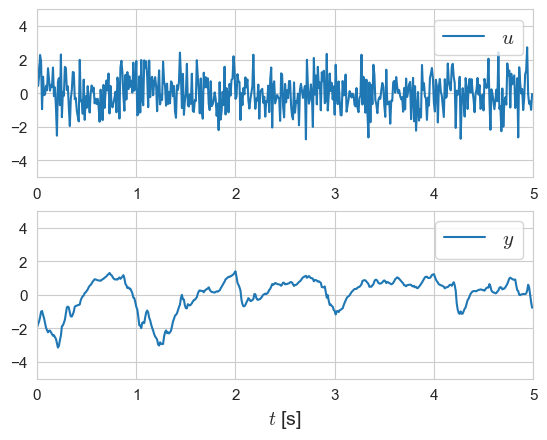

In [192]:
Ts = 1e-2
T = 5  # ts*self.seq_len# * 2
t = np.arange(0, T, Ts)
plt.subplot(211)
plt.plot(t, u, c='tab:blue', alpha=1)
plt.legend(['$u$'], prop={'size': 15}, loc = 'upper right')
plt.xlim(0, 5)
plt.ylim(-5, 5)
#plt.grid()
plt.subplot(212)
plt.plot(t, y, c='tab:blue', alpha=1)
plt.legend(['$y$'], prop={'size': 15}, loc = 'upper right')
plt.xlabel("$t$ [s]")
plt.xlim(0, 5)
plt.ylim(-5, 5)
#plt.grid()

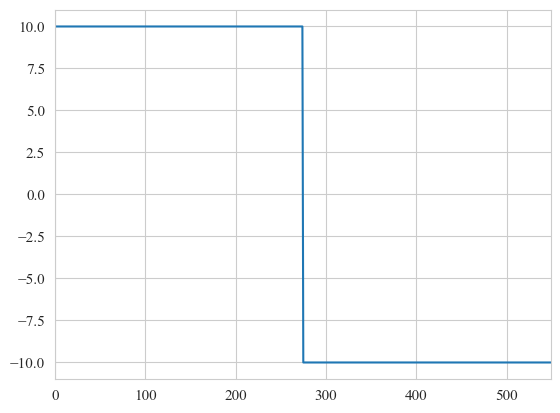

In [161]:
# reference
Ts = 1e-2
#t_CL = np.arange(0, 5, Ts)

s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = 5.5
t_CL = np.arange(0, T_cl, Ts)

r = np.zeros(t_CL.shape)
#only one ref should be chosen
steps_1 = 0
steps_10 = 1
steps_100 = 0

ramp1 = 0
ramp10 = 0
ramp100 = 0 # actually 25 (?)
ramp_minus10 = 0
ramp_minus100 = 0 

parabolic1 = 0
parabolic10 = 0
parabolic100 = 0 # interesting

sine_1 = 0 # A = 1 , one period
sine_2 = 0 # A = 50 , one period 
sine_3 = 0 # A = 1 , 10 periods
sine_4 = 0 # A =50, 10 periods , this can't be tracked at all
sine_5 = 0 # A = 1, 4 periods , qui si vede che è lento, in ritardo
sine_6 = 0 # A = 50 , 4 periods

impulse1 = 0 # si vede che c' è sempre un oscillazione assoluta
impulse10 = 0  # l impulso dura 10 istanti,anche più, ma non se ne accorge proprio
impulse100 = 0



if steps_1 or ramp1 or parabolic1 or sine_1 or sine_3 or sine_5 or impulse1: value = 1
if steps_10 or ramp10 or parabolic10 or impulse10: value = 10
if  sine_2 or sine_4 or sine_6 : value = 50
if steps_100 or ramp100 or parabolic100 or impulse100 : value = 100
if ramp_minus100 : value = -100
if ramp_minus10: value = -10
if sine_1 or sine_2 : freq = 1/T_cl
if sine_3 or sine_4 : freq = 2
if sine_5 or sine_6 : freq = 4/T_cl

if (steps_1 or steps_10 or steps_100) :
    r[t_CL < T_cl/2] = value
    r[(t_CL >= T_cl/2) & (t_CL < T_cl)] = - value

if (ramp1 or ramp10 or ramp100 or ramp_minus100 or ramp_minus10) :
    ramp_up_indices = t_CL <= T_cl/2
    r[ramp_up_indices] = t_CL[ramp_up_indices]*value / T_cl/2
    ramp_down_indices = (t_CL > T_cl/2) & (t_CL <= T_cl)
    r[ramp_down_indices] = (T_cl - t_CL[ramp_down_indices])*value / T_cl/2
    
if ( parabolic1 or parabolic10 or parabolic100 ) :
    ramp_up_indices = t_CL <= T_cl/2
    r[ramp_up_indices] = (t_CL[ramp_up_indices]**2)*value / (T_cl/2**2)
    ramp_down_indices = (t_CL > T_cl/2) & (t_CL <= T_cl)
    r[ramp_down_indices] = ((T_cl - t_CL[ramp_down_indices])**2)*value / (T_cl/2**2)
    
if (sine_1 or sine_2 or sine_3 or sine_4 or sine_5 or sine_6 ):
    r = value * np.sin(2 * np.pi * freq * t_CL)

if( impulse1 or impulse100 or impulse10 ):
    r[((len(t_CL) // 2)-10) : ((len(t_CL) // 2)+10)] = value

plt.plot(r)

In [162]:
n_testing = 1
H = 5

y_log = np.zeros((n_testing,len(t_CL)))
e_log = np.zeros((n_testing,len(t_CL)))
u_log = np.zeros((n_testing,len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')
# problem data

with torch.no_grad():
    for n_testing in range(1):#len(data_test)):
        
        e = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        # This is like t=0, for our model we need u(-1).
        u_i = 1e-6 # u(-1)
        x_1_i = 1e-6
        x_2_i = 1e-6
        y_i = 1e-6
        
        u_log[n_testing,0] = u_i
        y_log[n_testing,0] = y_i
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            u_i = torch.Tensor([[[u_i]]])   # first you add u(t)
            u = torch.cat((u,u_i / 1000),2)
            
            e_i = torch.Tensor([[[r[i] - y_i]]]) # e(t)
            e = torch.cat((e,e_i / 0.3),2)  #CAMBIARE QUI
            
            if i < H:
                pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
            
            u_i = pred[:,-1,:].item() * 1000 # u(t)
            
            # Controller u(t) = C(e(t-1),u(t-1))
            
            y_1_i, _, x_1_i = lsim(G1_tf, u_i, np.array([ Ts]), x_1_i, return_x = True)
            
            #y_1_i = y_1_i[-1]
            y_1_i = y_1_i.reshape(-1, 1)
            # F
            y_2_i = nn_fun(y_1_i)
            
            # G2
            y_3_i, _, x_2_i = lsim(G2_tf, y_2_i, np.array([Ts]), x_2_i, return_x = True)
            y_3_i = y_3_i[-1]
            y_i = y_3_i
        
            e_log[n_testing,i] = e_i
            if (i+1) < len(t_CL) :
              u_log[n_testing,i+1] = u_i
              y_log[n_testing,i+1] = y_i

/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1058: RuntimeWarning: invalid value encountered in scalar divide
  dt = (T[-1] - T[0]) / (n_steps - 1)


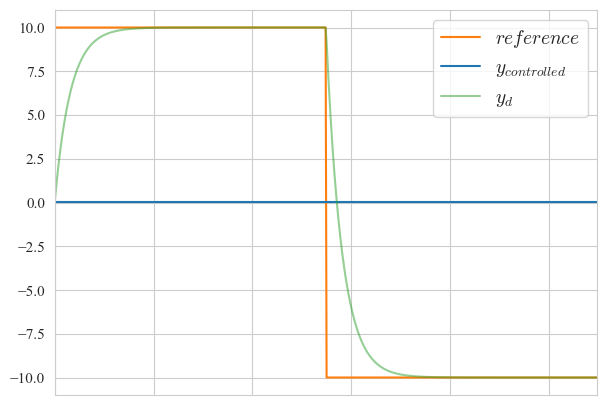

In [163]:
y_d = lsim(M, r,t_CL )[0]


fig = plt.figure(figsize=(7, 5))

plt.plot(t_CL, r, label="$r$", c='tab:orange')
plt.plot(t_CL, y_log.T, label="$y$", c='tab:blue', alpha=1)
plt.plot(t_CL, y_d, label="$y_d$", c='tab:green', alpha= 0.5)
plt.legend(['$reference$','$y_{controlled}$', '$y_{d}$'], loc = 'upper right', prop={'size': 14})
plt.tick_params('x', labelbottom=False)

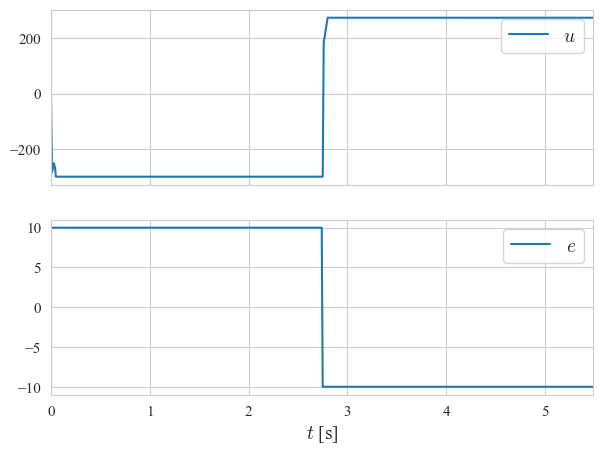

In [164]:
fig = plt.figure(figsize=(7, 5))

plt.subplot(211)
plt.plot(t_CL, u_log.T, c='tab:blue', alpha=1)
plt.legend(['$u$'] , loc = 'upper right', prop={'size': 14})
plt.tick_params('x', labelbottom=False)

plt.subplot(212)
plt.plot(t_CL, e_log.T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$e$'], loc = 'upper right',prop={'size': 14})

# plt.savefig('transformer_controller.pdf')

plt.show()

In [165]:
e_log = e_log.reshape(-1)

## CALCULATE MSE (r, y) 
error_tot = 0
for k in range(len(e_log)):
    squared_error = e_log[k] * e_log[k]
    error_tot += squared_error 
MSE = error_tot / len(e_log)
print(f"MSE (r,y) : {MSE:.5f}")
y_log = y_log.reshape(-1)

##CALCULATE MSE ( y_d , y )

Mr_error = y_d - y_log
mr_error_tot = 0
for k in range(len(Mr_error)):
    mr_squared_error = Mr_error[k] * Mr_error[k]
    mr_error_tot += mr_squared_error 
MSE2 = mr_error_tot / len(Mr_error)
print(f"MSE (y_d,y): {MSE2:.5f}")


MSE (r,y) : 100.00000
MSE (y_d,y): 89.80883


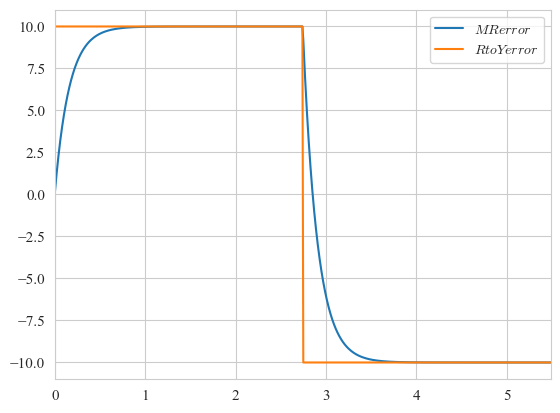

In [166]:
plt.plot(t_CL, Mr_error)
plt.plot(t_CL, e_log, c='tab:orange')
plt.legend(['$MRerror$','$RtoYerror$'])


PLOT DISTRIBUTION OF E AND U 



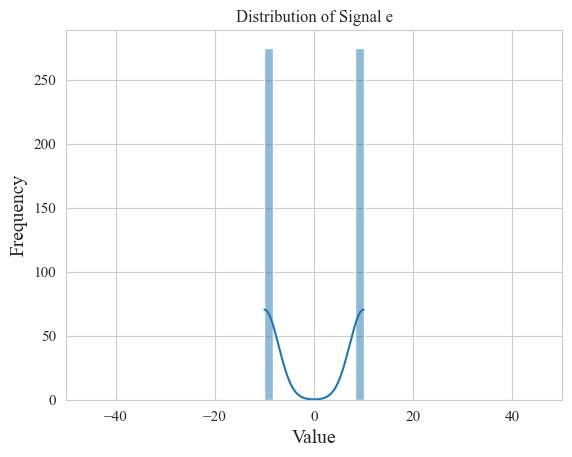

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example signal u
e = e_log.T

# Plot histogram and KDE using Seaborn
sns.histplot(e, kde=True)
plt.title('Distribution of Signal e')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(-50, 50)
plt.show()

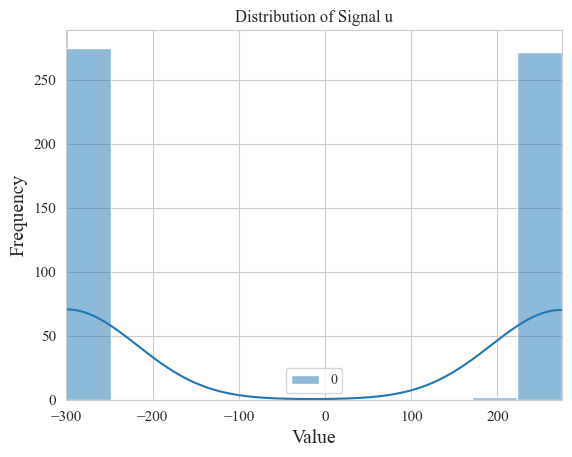

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example signal u
u = u_log.T

# Plot histogram and KDE using Seaborn
sns.histplot(u, kde=True)
plt.title('Distribution of Signal u')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()